# Grid-Search on: <br> &emsp;Document Vectors using Cosine Similarity with Naive Bayesian Sub-Sampling (DVNB) + RoBERTa

In [1]:
import os
from test_with_origin import restore_order
from ensemble_gs import ImdbSentimentClf, TrivialScaler, read_embeddings, read_logs

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import pickle
import json
import re
from typing import List
from original_to_1gram import normalize_text

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

sns.set(font_scale=1.6, style="whitegrid")

Finetune RoBERTa and extract RoBERTa embeddings with roberta/roberta.py before running this notebook!!!

!python roberta/roberta.py

## The Grid-Search Experiment
### Preparations

Because the 2 parts of docuemtn vectors were trained on different versions of the IMDB dataset (all from the original dataset but with different preprocessing and in different document orders), some auxilliary functions are needed to make sure that then are concatenated correctly.

In [2]:
def read_jsonl(path):
    ids = []
    texts = []
    labels = []
    with open(path, encoding='utf8') as f:
        for line in f:
            d = json.loads(line)
            ids.append(d['id'])
            texts.append(d['text'])
            labels.append(d['label'])
    return ids, texts, labels

def read_dv_jsonl(path):
    dv_train = []
    dv_dev = []
    dv_test = []
    y_train = []
    y_dev = []
    y_test = []
    with open(path) as f:
        for line in f:
            d = json.loads(line)
            split = d["split"]
            if split=='train':
                dv_train.append(d["embs"])
                y_train.append(d["label"])
            elif split=="dev":
                dv_dev.append(d["embs"])
                y_dev.append(d["label"])
            elif split == "test":
                dv_test.append(d["embs"])
                y_test.append(d["label"])
    return [*map(np.array, (dv_train, dv_dev, dv_test, y_train, y_dev, y_test))]
    


In [3]:
## read embeddings from both sources
# read Document Vectors using Cosine Simialrity with NB sub-sampling and labels
embedding_train, embedding_dev, embedding_test, y_train, y_dev, y_test = read_dv_jsonl('imdb_runs_results/imdb_vectors_nb_1e-04_120epoch.jsonl')

# read RoBERTa embeddings
rembs_train = np.load("roberta/embs/emb_train.npy")
rembs_dev = np.load("roberta/embs/emb_dev.npy")
rembs_test = np.load("roberta/embs/emb_test.npy")

### Run the grid-search

In [4]:
# The grid of feature-wise scaling
dv_scalers = {
    'none': TrivialScaler(), 
    #'standard': StandardScaler(with_mean=False), 
    'standard_with_mean': StandardScaler(with_mean=True), 
}
re_scalers = {
    'none': TrivialScaler(), 
    'standard': StandardScaler(with_mean=True), 
    #'minmax': MaxAbsScaler(), 
}


In [5]:
# As in some cases the concatenation matrix is very baddly conditioned, the solver may not converge within the niter limit. 
# Here suppress the corresponding warnings to keep the stdout clean
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
np.random.seed(12)
# run the experiment
his = {}
rs = np.logspace(-3, 7, 21)
Cs = np.logspace(-9, 1, 21)
for dv_scaler_name, dv_scaler in dv_scalers.items():
    for bon_scaler_name, bon_scaler in re_scalers.items():
        stclf = ImdbSentimentClf(r=rs, C=Cs, dv_scaler=dv_scaler, bon_scaler=bon_scaler, cv=3)
        best = stclf.gridsearch(embedding_train, rembs_train, y_train, embedding_dev, rembs_dev, y_dev)
        test_name = f'dv_{dv_scaler_name}+rb_{bon_scaler_name}'
        his[test_name] = stclf.rec
        with open('test_logs/dvnb+roberta_logs.pkl', 'wb') as f:
            pickle.dump(his, f)
        print(test_name, best)


dv_none+rb_none {'C': 0.0001, 'r': 10000.0, 'acc': 0.9592}
dv_none+rb_standard {'C': 1e-05, 'r': 31622.776601683792, 'acc': 0.959}
dv_standard_with_mean+rb_none {'C': 0.0001, 'r': 316.22776601683796, 'acc': 0.9588}
dv_standard_with_mean+rb_standard {'C': 3.1622776601683795e-05, 'r': 100.0, 'acc': 0.9586}


## Results of the grid-search

In [6]:
with open('test_logs/dvnb+roberta_logs.pkl', 'rb') as f:
    his = pickle.load(f)
df = read_logs(his)

In [7]:
df = df.rename(columns={"BON scaling": "RoBERTa scaling", "DV scaling": "DVNB scaling"})
df = df.replace("standard_with_mean", "standard")

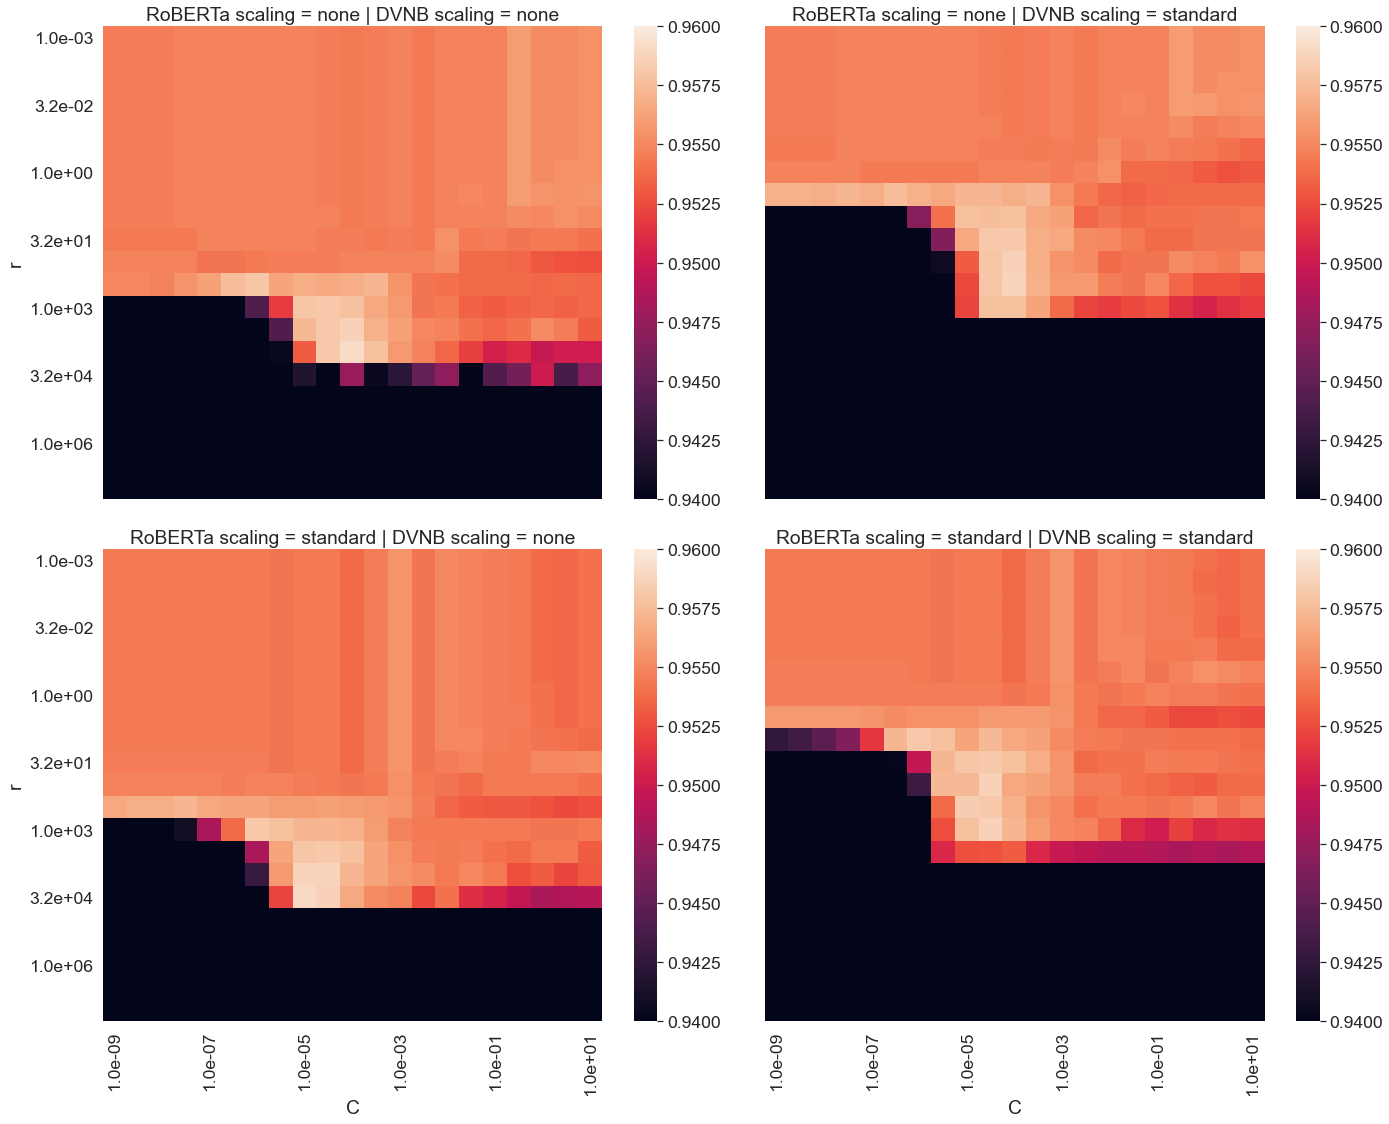

In [8]:
def draw_heatmap(x, y, v, **kwargs):
    data = kwargs.pop("data")
    d = data.pivot(index=y, columns=x, values=v)
    d = d.rename(lambda x: f"{x:.1e}", axis=0)
    d = d.rename(lambda x: f"{x:.1e}", axis=1)
    ax = sns.heatmap(d,  **kwargs)
g = sns.FacetGrid(df, col="DVNB scaling", row="RoBERTa scaling")
g.map_dataframe(draw_heatmap, "C", "r", "acc", vmin=0.94, vmax=0.96)
g.fig.set_size_inches(20, 16)
g.fig.tight_layout()
g.savefig("figures/dvnb_rb_gs.jpg")

In [9]:
# g = sns.relplot(x="C", y="acc", hue="r", col="DVNB scaling", row="RoBERTa scaling", data=df, hue_norm=LogNorm(1e-7, 1e2), legend="full")
# g.set(xscale="log")
# g.set(ylim=(0.92, 0.96))
# g.savefig("figures/dvnb_rb_gs.jpg")

Top 4 configurations in the grid-search based on validation scores

In [10]:
top = df.sort_values(by="acc", ascending=False).head(4).copy()
top

,C,r,acc,DVNB scaling,RoBERTa scaling
304,0.00010,10000.000000,0.9592,none,none
323,0.00001,31622.776602,0.9590,none,standard
302,0.00001,10000.000000,0.9588,none,standard
241,0.00010,316.227766,0.9588,standard,none


## Test the top 4 configurations on the test set

In [11]:
embedding_train = np.vstack([embedding_train, embedding_dev])
rembs_train = np.vstack([rembs_train, rembs_dev])

In [12]:
y_train = np.concatenate([y_train, y_dev])

In [13]:
lr = LogisticRegression()

sd = StandardScaler(with_mean=True)
embedding_train_sd = sd.fit_transform(embedding_train)
embedding_test_sd = sd.transform(embedding_test)

rembs_train_sd = sd.fit_transform(rembs_train)
rembs_test_sd = sd.transform(rembs_test)

for i, a in top.iterrows():
    dv_train = embedding_train_sd if a["DVNB scaling"] == "standard" else embedding_train
    dv_test = embedding_test_sd if a["DVNB scaling"] == "standard" else embedding_test

    rb_train = rembs_train_sd if a["RoBERTa scaling"] == "standard" else rembs_train
    rb_test = rembs_test_sd if a["RoBERTa scaling"] == "standard" else rembs_test

    lr.set_params(C=a["C"])
    lr.fit(np.hstack([dv_train * a["r"],rb_train]), y_train)
    test_score = lr.score(np.hstack([dv_test * a["r"], rb_test]), y_test)
    top.loc[i, "test score"] = test_score

top   

,C,r,acc,DVNB scaling,RoBERTa scaling,test score
304,0.00010,10000.000000,0.9592,none,none,0.95940
323,0.00001,31622.776602,0.9590,none,standard,0.95928
302,0.00001,10000.000000,0.9588,none,standard,0.96068
241,0.00010,316.227766,0.9588,standard,none,0.95976


## DV-cosine and RoBERTa alone (without ensemble)
### Accuracy on the test set

In [14]:

lgcv = LogisticRegressionCV(Cs=np.logspace(-7, 4, 23), tol=0.001)
lgcv.fit(rembs_train, y_train)
rb_test_score = lgcv.score(rembs_test, y_test)

lgcv.fit(embedding_train, y_train)
dv_test_score = lgcv.score(embedding_test, y_test)
print("RoBERTa score:", rb_test_score)
print("DVNB score:", dv_test_score)

RoBERTa score: 0.95792
DVNB score: 0.93356


### Stats

In [15]:
mag = []
mag.append({
    "name": "DVNB",
    "ndim": embedding_train.shape[1],
    "mean norm": np.linalg.norm(embedding_train, axis=-1).mean(),
    "mean norm avg": np.linalg.norm(embedding_train, axis=-1).mean()/embedding_train.shape[1],
})
mag.append({
    "name": "RoBERTa",
    "ndim": rembs_train.shape[1],
    "mean norm": np.linalg.norm(rembs_train, axis=-1).mean(),
    "mean norm avg":  np.linalg.norm(rembs_train, axis=-1).mean()/rembs_train.shape[1]
})
pd.DataFrame.from_records(mag, index="name")

,ndim,mean norm,mean norm avg
name,,,
DVNB,500,0.306773,0.000614
RoBERTa,768,14.571285,0.018973
